# Project 4 - Analysis of Qualitative Dependent Variable Models
## Group Members:
1. Andrea Riccardo Assenza (006548376)
2. Kojo Manu (206545334)
3. Joshua Onozawa (506549019)
4. Rizky Rizaldi Ronaldo (706377502)

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random; random.seed(10)  # pre-setting seed
from scipy import stats
from scipy.stats import norm, chi2, f
import wooldridge as woo
from ydata_profiling import ProfileReport

# For model fitting
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.graphics import regressionplots
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, het_white, het_goldfeldquandt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegressionCV

# Subset regressions & feature selection
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Boruta
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

# Missing data imputation
from sklearn.impute import KNNImputer
from statsmodels.imputation import mice

# Model evaluation
from sklearn.metrics import *

# Ordered choice model
from statsmodels.miscmodels.ordinal_model import OrderedModel

# This just gets rid of annoying warnings
import warnings
warnings.filterwarnings("ignore")

# For R kernel
# Note: need working copy of R, initiate chunk with `%%R`
import rpy2.ipython
%load_ext rpy2.ipython

## Qualitative Dependent Variable Models

### 1. Introduction
In this section, we will analyze the `Kaggle Crash Dataset (2016-2023)`, which provides detailed records of vehicle crash incidents over 8 years. The dataset aggregates information from multiple open-source crash datasets.

*Link: https://www.kaggle.com/datasets/trsaivarun/crash-dataset-2016-2023?resource=download*

The goal is to answer the following question: **What are the significant factors that determine whether a vehicle crash leads to an injury?**

By employing qualitative dependent variable models, we will explore how various features (e.g., weather, road conditions, vehicle details, and driver behavior) contribute to crash severity.

#### Dataset Overview
- Period: 2016 to 2023
- Content: Detailed records of vehicle crash incidents, including categorical and numerical attributes.
- Purpose: Designed for machine learning practice and accident pattern analysis.

### 2. Descriptive Analysis

#### Data Examination and Cleaning

In [2]:
crash = pd.read_csv('crash_data.csv')
crash.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3170003V,240000438,Montgomery County Police,Property Damage Crash,01/03/2024 02:55:00 PM,NaN,NaN,NaN,NaN,IN FRONT OF 18900 BIRDSEYE DR,...,0,No,No,2017,LEXUS,SUV,NO MISUSE,39.165005,-77.249310,"(39.16500483, -77.24931)"
1,MCP3254003K,230072050,Montgomery County Police,Injury Crash,12/16/2023 12:36:00 PM,Maryland (State),GERMANTOWN RD,County,MIDDLEBROOK RD,NaN,...,35,No,No,2010,TOYT,PRIUS,NO MISUSE,39.178776,-77.267190,"(39.17877577, -77.26718974)"
2,EJ7887003Q,230074270,Gaithersburg Police Depar,Injury Crash,12/29/2023 12:00:00 PM,Maryland (State),GREAT SENECA HWY,Municipality,KENTLANDS BLVD,NaN,...,35,No,No,2021,SUBARU,FORRESTER,NO MISUSE,39.123574,-77.231769,"(39.12357374, -77.231769)"
3,MCP2674004J,230064598,Montgomery County Police,Property Damage Crash,11/05/2023 09:07:00 PM,Maryland (State),WOODFIELD RD,County,GLENDALOUGH RD,NaN,...,40,No,No,2019,DODGE,CHARGER,NO MISUSE,39.211742,-77.171461,"(39.21174219, -77.17146065)"
4,MCP25280008,230067019,Montgomery County Police,Property Damage Crash,11/18/2023 12:40:00 AM,Maryland (State),CLARKSBURG RD,Maryland (State),CLARKSBURG RD,NaN,...,20,No,No,2014,NISSAN,ROGUE,NaN,39.228915,-77.289091,"(39.22891483, -77.28909117)"


In [3]:
print(crash.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172105 entries, 0 to 172104
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Report Number                   172105 non-null  object 
 1   Local Case Number               172105 non-null  object 
 2   Agency Name                     172105 non-null  object 
 3   ACRS Report Type                172105 non-null  object 
 4   Crash Date/Time                 172105 non-null  object 
 5   Route Type                      155132 non-null  object 
 6   Road Name                       156168 non-null  object 
 7   Cross-Street Type               155099 non-null  object 
 8   Cross-Street Name               156154 non-null  object 
 9   Off-Road Description            15935 non-null   object 
 10  Municipality                    19126 non-null   object 
 11  Related Non-Motorist            5463 non-null    object 
 12  Collision Type  

- The dataset has 172,105 rows and 43 columns.
- 39 object columns: categorical variables.
- Some columns have moderate to severe missing data: we won't use them in our model.

In [4]:
print(crash.describe())

         Speed Limit   Vehicle Year       Latitude      Longitude
count  172105.000000  172105.000000  172105.000000  172105.000000
mean       32.549752    1966.306946      39.083119     -77.112343
std        11.059987     340.615468       0.072032       0.098571
min         0.000000       0.000000      37.720000     -79.486000
25%        25.000000    2006.000000      39.024417     -77.189327
50%        35.000000    2011.000000      39.074933     -77.105412
75%        40.000000    2015.000000      39.139742     -77.039592
max        75.000000    9999.000000      39.990414     -75.527708


- `Vehicle Year` has unrealistic values for min and max, so we will remove these.

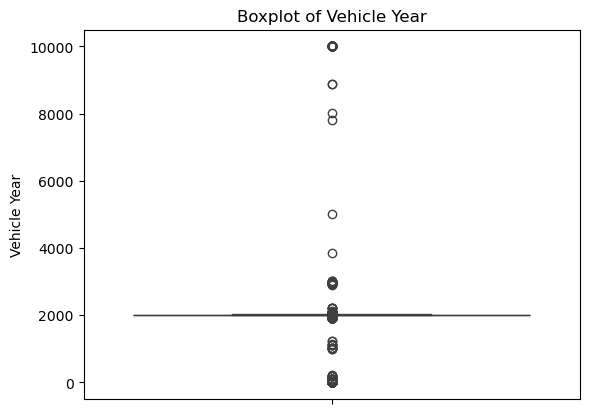

In [5]:
plt.figure()
sns.boxplot(crash['Vehicle Year'])
plt.title('Boxplot of Vehicle Year')
plt.show()

- We will filter years before 1885 (since cars were invented in 1885-1886) and after 2023 (the dataset's time period is from 2016 to 2023).

In [6]:
crash_filtered = crash[crash['Vehicle Year'] > 1885]
crash_filtered = crash_filtered[crash_filtered['Vehicle Year'] < 2024]
print(crash_filtered.describe())

         Speed Limit   Vehicle Year       Latitude      Longitude
count  167874.000000  167874.000000  167874.000000  167874.000000
mean       32.664349    2010.534913      39.083300     -77.112433
std        10.991859       6.734921       0.072067       0.098650
min         0.000000    1900.000000      37.720000     -79.486000
25%        30.000000    2006.000000      39.024696     -77.189258
50%        35.000000    2012.000000      39.075065     -77.105590
75%        40.000000    2015.000000      39.139808     -77.039752
max        75.000000    2023.000000      39.990414     -75.527708


In [7]:
# Percentage of data that is null
null_percentage = (crash_filtered.isnull().sum() / len(crash_filtered)) * 100
print(null_percentage)

Report Number                      0.000000
Local Case Number                  0.000000
Agency Name                        0.000000
ACRS Report Type                   0.000000
Crash Date/Time                    0.000000
Route Type                         9.580995
Road Name                          8.978758
Cross-Street Type                  9.600653
Cross-Street Name                  8.987097
Off-Road Description              91.022433
Municipality                      88.890477
Related Non-Motorist              97.035872
Collision Type                     0.319287
Weather                            7.653955
Surface Condition                 11.402004
Light                              0.835746
Traffic Control                   14.675888
Driver Substance Abuse            18.231531
Non-Motorist Substance Abuse      97.654789
Person ID                          0.000000
Driver At Fault                    0.000000
Injury Severity                    0.000000
Circumstance                    

- We will exclude columns containing 50% or more null values to minimize data loss when applying the `.dropna()` method.

In [8]:
crash_filtered = crash_filtered[null_percentage[null_percentage < 50].index]

In [9]:
print(len(crash_filtered['Report Number'].unique()))
print(len(crash_filtered['Report Number']))

95243
167874


In [10]:
print(len(crash_filtered['Local Case Number'].unique()))
print(len(crash_filtered['Local Case Number']))

106779
167874


- There are rows with the same `Report Number` and `Local Case Number`.
- We will verify if these rows are true duplicates or contain additional unique information.

In [11]:
# Check duplicates for Report Number
duplicate_report_rows = crash_filtered[crash_filtered.duplicated(subset='Report Number', keep=False)]

# Check if rows with duplicate Report Number are identical
identical_report_rows = duplicate_report_rows[duplicate_report_rows.duplicated(keep=False)]

# Check if rows with duplicate Report Number have differences
non_identical_report_rows = duplicate_report_rows.drop_duplicates(keep=False)

# Print summary for Report Number duplicates
print("Total duplicate Report Numbers:", duplicate_report_rows['Report Number'].nunique())
print("Rows with identical duplicates (Report Number):", len(identical_report_rows))
print("Rows with non-identical duplicates (Report Number):", len(non_identical_report_rows), f'\n')

# Repeat the same process for Local Case Number
duplicate_case_rows = crash_filtered[crash_filtered.duplicated(subset='Local Case Number', keep=False)]

# Check if rows with duplicate Local Case Number are identical
identical_case_rows = duplicate_case_rows[duplicate_case_rows.duplicated(keep=False)]

# Check if rows with duplicate Local Case Number have differences
non_identical_case_rows = duplicate_case_rows.drop_duplicates(keep=False)

# Print summary for Local Case Number duplicates
print("Total duplicate Local Case Numbers:", duplicate_case_rows['Local Case Number'].nunique())
print("Rows with identical duplicates (Local Case Number):", len(identical_case_rows))
print("Rows with non-identical duplicates (Local Case Number):", len(non_identical_case_rows))

Total duplicate Report Numbers: 63553
Rows with identical duplicates (Report Number): 0
Rows with non-identical duplicates (Report Number): 136184 

Total duplicate Local Case Numbers: 54075
Rows with identical duplicates (Local Case Number): 0
Rows with non-identical duplicates (Local Case Number): 115170


In [12]:
# Sample of non-identical Report Number duplicates
non_identical_report_rows.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Collision Type,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3170003V,240000438,Montgomery County Police,Property Damage Crash,01/03/2024 02:55:00 PM,NaN,NaN,NaN,NaN,OPPOSITE DIRECTION SIDESWIPE,...,0,No,No,2017,LEXUS,SUV,NO MISUSE,39.165005,-77.249310,"(39.16500483, -77.24931)"
2,EJ7887003Q,230074270,Gaithersburg Police Depar,Injury Crash,12/29/2023 12:00:00 PM,Maryland (State),GREAT SENECA HWY,Municipality,KENTLANDS BLVD,SAME DIR REAR END,...,35,No,No,2021,SUBARU,FORRESTER,NO MISUSE,39.123574,-77.231769,"(39.12357374, -77.231769)"
5,EJ7887003Q,230074270,Gaithersburg Police Depar,Injury Crash,12/29/2023 12:00:00 PM,Maryland (State),GREAT SENECA HWY,Municipality,KENTLANDS BLVD,SAME DIR REAR END,...,35,No,No,1991,MERCEDES-BENZ,L350,NO MISUSE,39.123574,-77.231769,"(39.12357374, -77.231769)"
8,MCP2667008Z,230073137,Montgomery County Police,Injury Crash,12/22/2023 01:00:00 PM,Maryland (State),WOODFIELD RD,County,SNOUFFERS SCHOOL RD,SAME DIR REAR END,...,35,No,No,2009,HYUN,SPORT UTILITY,UNKNOWN,39.159079,-77.160541,"(39.15907918, -77.16054149)"
11,MCP2667008Z,230073137,Montgomery County Police,Injury Crash,12/22/2023 01:00:00 PM,Maryland (State),WOODFIELD RD,County,SNOUFFERS SCHOOL RD,SAME DIR REAR END,...,35,No,No,1999,HOND,UT,NO MISUSE,39.159079,-77.160541,"(39.15907918, -77.16054149)"


In [13]:
# Sample of non-identical Local Case Number duplicates
non_identical_case_rows.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Collision Type,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3170003V,240000438,Montgomery County Police,Property Damage Crash,01/03/2024 02:55:00 PM,NaN,NaN,NaN,NaN,OPPOSITE DIRECTION SIDESWIPE,...,0,No,No,2017,LEXUS,SUV,NO MISUSE,39.165005,-77.249310,"(39.16500483, -77.24931)"
2,EJ7887003Q,230074270,Gaithersburg Police Depar,Injury Crash,12/29/2023 12:00:00 PM,Maryland (State),GREAT SENECA HWY,Municipality,KENTLANDS BLVD,SAME DIR REAR END,...,35,No,No,2021,SUBARU,FORRESTER,NO MISUSE,39.123574,-77.231769,"(39.12357374, -77.231769)"
5,EJ7887003Q,230074270,Gaithersburg Police Depar,Injury Crash,12/29/2023 12:00:00 PM,Maryland (State),GREAT SENECA HWY,Municipality,KENTLANDS BLVD,SAME DIR REAR END,...,35,No,No,1991,MERCEDES-BENZ,L350,NO MISUSE,39.123574,-77.231769,"(39.12357374, -77.231769)"
8,MCP2667008Z,230073137,Montgomery County Police,Injury Crash,12/22/2023 01:00:00 PM,Maryland (State),WOODFIELD RD,County,SNOUFFERS SCHOOL RD,SAME DIR REAR END,...,35,No,No,2009,HYUN,SPORT UTILITY,UNKNOWN,39.159079,-77.160541,"(39.15907918, -77.16054149)"
11,MCP2667008Z,230073137,Montgomery County Police,Injury Crash,12/22/2023 01:00:00 PM,Maryland (State),WOODFIELD RD,County,SNOUFFERS SCHOOL RD,SAME DIR REAR END,...,35,No,No,1999,HOND,UT,NO MISUSE,39.159079,-77.160541,"(39.15907918, -77.16054149)"


- Based on the results, rows with duplicate `Report Number` and `Local Case Number` are not exact duplicates, meaning they contain some varying data.
- However, given the variables of interest (e.g., weather, light, and road conditions are the same for vehicles of the same crash), retaining these duplicates could inflate certain values and introduce bias into the analysis.
- To avoid this potential issue and ensure each crash is represented only once, we will drop rows with duplicate `Report Number` and `Local Case Number`.

In [14]:
crash_filtered = crash_filtered.drop_duplicates(subset='Report Number')
print(len(crash_filtered['Local Case Number'].unique()))
print(len(crash_filtered['Local Case Number']))

95173
95243


In [15]:
crash_filtered = crash_filtered.drop_duplicates(subset='Local Case Number')
print(len(crash_filtered['Report Number'].unique()) == len(crash_filtered['Report Number']))
print(len(crash_filtered['Local Case Number'].unique()) == len(crash_filtered['Local Case Number']))

True
True


- `crash_filtered` is the data with:
    - Cleaned unrealistic `Vehicle Year`
    - Dropped columns with 50% or more null data
    - Removed crashes with the same `Report Number` and `Local Case Number`

#### Variable Selection and Binary Conversion

In [16]:
crash_filtered.columns

Index(['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Type',
       'Cross-Street Name', 'Collision Type', 'Weather', 'Surface Condition',
       'Light', 'Traffic Control', 'Driver Substance Abuse', 'Person ID',
       'Driver At Fault', 'Injury Severity', 'Driver Distracted By',
       'Drivers License State', 'Vehicle ID', 'Vehicle Damage Extent',
       'Vehicle First Impact Location', 'Vehicle Second Impact Location',
       'Vehicle Body Type', 'Vehicle Movement', 'Vehicle Continuing Dir',
       'Vehicle Going Dir', 'Speed Limit', 'Driverless Vehicle',
       'Parked Vehicle', 'Vehicle Year', 'Vehicle Make', 'Vehicle Model',
       'Equipment Problems', 'Latitude', 'Longitude', 'Location'],
      dtype='object')

- From the above, we will select `Weather`, `Surface Condition`, `Light`, `Driver Substance Abuse`, `Vehicle Year`, and `Speed Limit` as our dependent variable, and `Injury Severity` as our target variable.

In [17]:
crash_selected = crash_filtered[['Weather', 'Surface Condition', 'Light', 'Driver Substance Abuse', 'Injury Severity', 'Vehicle Year', 'Speed Limit']].dropna()

In [18]:
print(crash.shape)
print(crash_filtered.shape)
print(crash_selected.shape)

(172105, 43)
(95173, 38)
(62873, 7)


- We retained 36.5% of the original data from our filter and variable selection process.
- Approximately 66.1% of the filtered data is retained, which is reasonable.

In [19]:
crash_selected.head()

,Weather,Surface Condition,Light,Driver Substance Abuse,Injury Severity,Vehicle Year,Speed Limit
1,CLEAR,DRY,DAYLIGHT,NONE DETECTED,NO APPARENT INJURY,2010,35
2,CLEAR,DRY,DAYLIGHT,NONE DETECTED,SUSPECTED MINOR INJURY,2021,35
3,CLEAR,DRY,DARK LIGHTS ON,NONE DETECTED,NO APPARENT INJURY,2019,40
4,RAINING,WET,DARK LIGHTS ON,NONE DETECTED,NO APPARENT INJURY,2014,20
6,RAINING,WET,DARK LIGHTS ON,NONE DETECTED,NO APPARENT INJURY,2015,35


- We will examine the distribution of categorical variables using bar plots.  
- Based on the distribution, we will determine an appropriate binary split.

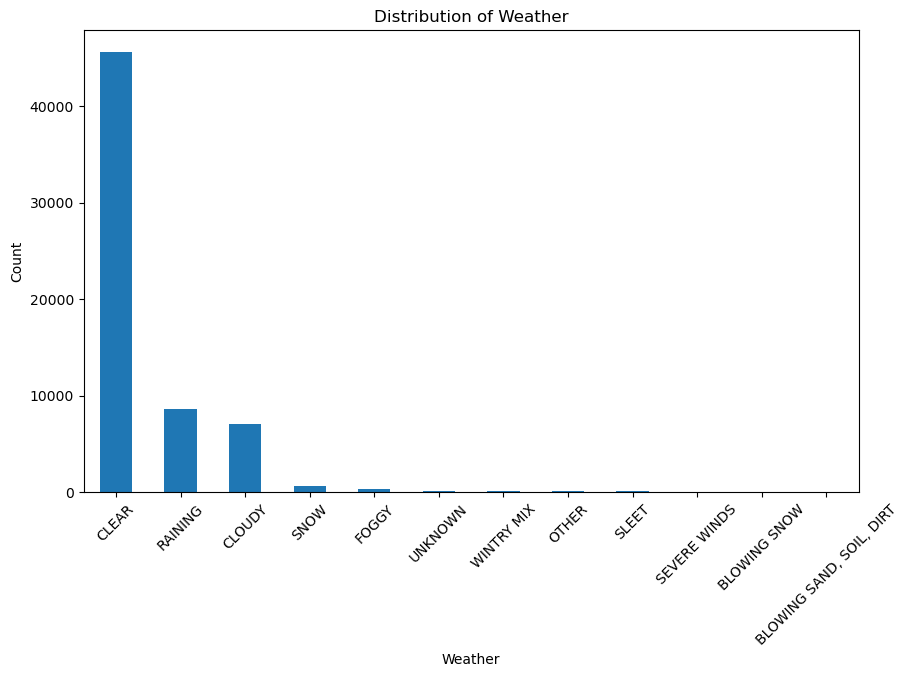

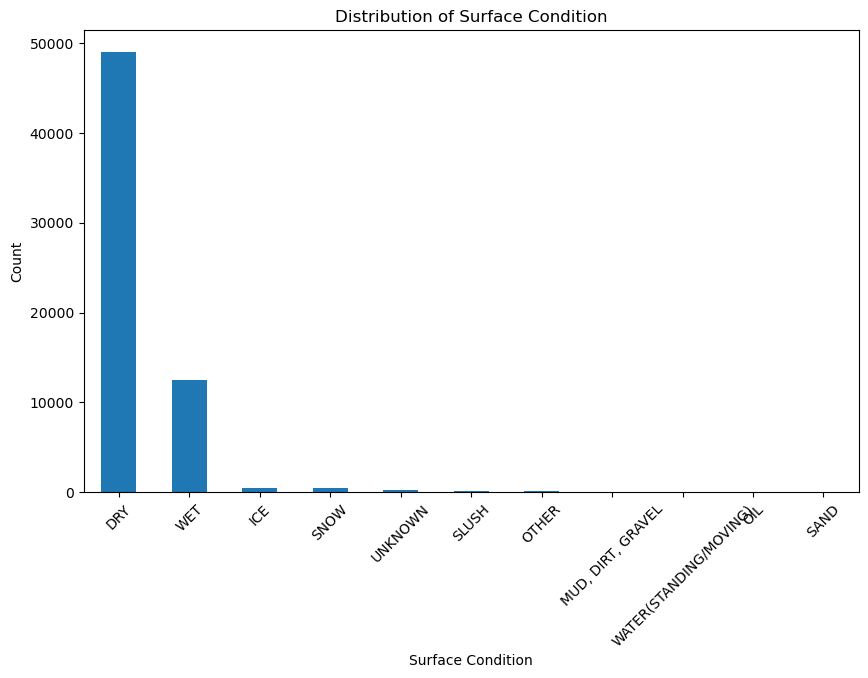

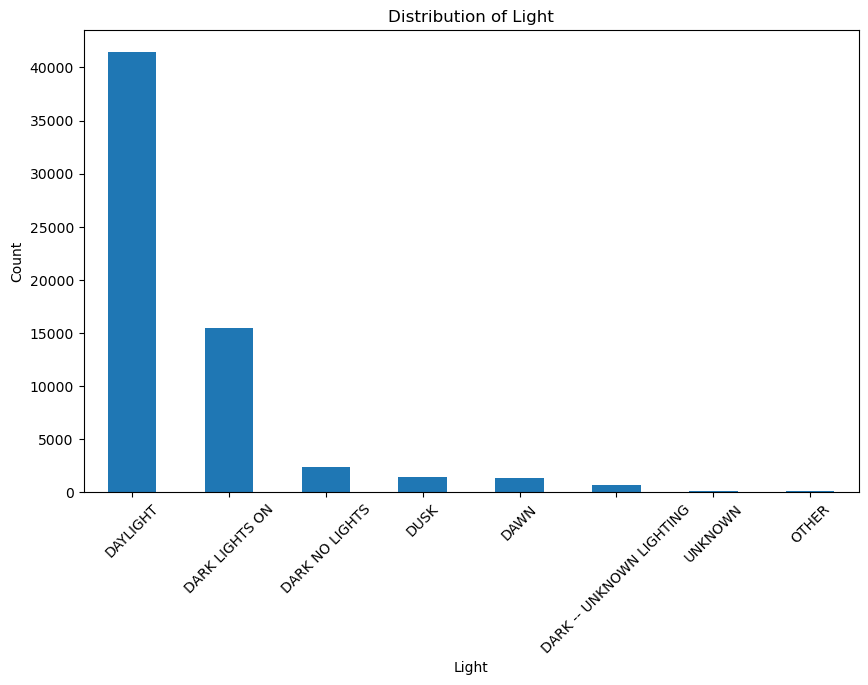

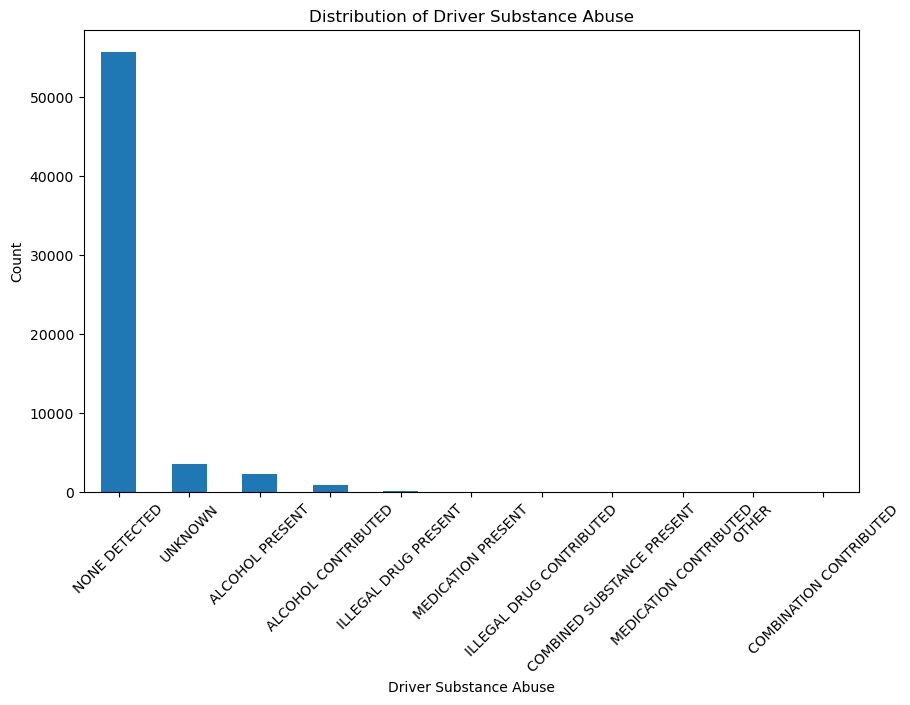

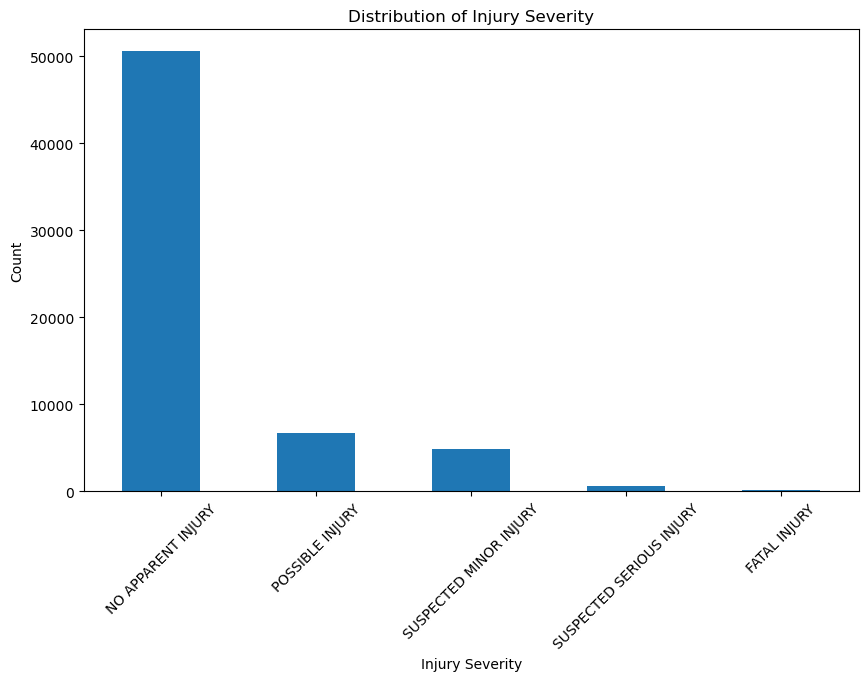

In [20]:
for column in ['Weather', 'Surface Condition', 'Light', 'Driver Substance Abuse', 'Injury Severity']:
    plt.figure(figsize = (10,6))
    crash_selected[column].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [21]:
for column in ['Weather', 'Surface Condition', 'Light', 'Driver Substance Abuse', 'Injury Severity']:
    print(f'Unique values of {column}:', crash_selected[column].unique(), f'\n')

Unique values of Weather: ['CLEAR' 'RAINING' 'CLOUDY' 'UNKNOWN' 'FOGGY' 'OTHER' 'SNOW' 'SLEET'
 'WINTRY MIX' 'BLOWING SNOW' 'SEVERE WINDS' 'BLOWING SAND, SOIL, DIRT'] 

Unique values of Surface Condition: ['DRY' 'WET' 'UNKNOWN' 'MUD, DIRT, GRAVEL' 'ICE' 'WATER(STANDING/MOVING)'
 'SNOW' 'SLUSH' 'OTHER' 'OIL' 'SAND'] 

Unique values of Light: ['DAYLIGHT' 'DARK LIGHTS ON' 'DARK NO LIGHTS' 'DUSK'
 'DARK -- UNKNOWN LIGHTING' 'DAWN' 'UNKNOWN' 'OTHER'] 

Unique values of Driver Substance Abuse: ['NONE DETECTED' 'UNKNOWN' 'ALCOHOL PRESENT' 'COMBINED SUBSTANCE PRESENT'
 'ILLEGAL DRUG PRESENT' 'ALCOHOL CONTRIBUTED' 'ILLEGAL DRUG CONTRIBUTED'
 'MEDICATION PRESENT' 'MEDICATION CONTRIBUTED' 'OTHER'
 'COMBINATION CONTRIBUTED'] 

Unique values of Injury Severity: ['NO APPARENT INJURY' 'SUSPECTED MINOR INJURY' 'FATAL INJURY'
 'SUSPECTED SERIOUS INJURY' 'POSSIBLE INJURY'] 



- Based on the bar graphs, we will convert the categorical variables to binary according to the following criteria:
    - `Precipitation`: A binary variable where 0 represents conditions unlikely to be associated with accidents (`CLEAR` or `CLOUDY`), and 1 represents all other conditions (e.g., rain, strong winds) that are more likely to contribute to accidents.
    - `Dry Surface`: A binary variable where 1 represents `DRY`, and 0 includes all other conditions.  
    - `Daylight`: A binary variable where 1 represents `DAYLIGHT`, and 0 includes all other lighting conditions.  
    - `Substance Abuse Detected`: A binary variable where 0 represents `NONE DETECTED`, and 1 includes all other cases.  
    - `Injury Occurred`: A binary variable where 0 represents `NO APPARENT INJURY`, and 1 includes all other levels of injury.  

In [22]:
# Define a function to map binary values
def map_binary_false(column, false_condition):
    return column.apply(lambda x: 0 if x in false_condition else 1)

def map_binary_true(column, true_condition):
    return column.apply(lambda x: 1 if x in true_condition else 0)

# Create a copy of the dataset
crash_binary = crash_selected.copy()

# Apply the transformations to create binary variables
crash_binary['Precipitation'] = map_binary_false(crash_binary['Weather'], ['CLEAR', 'CLOUDY'])
crash_binary['Dry_Surface'] = map_binary_true(crash_binary['Surface Condition'], ['DRY'])
crash_binary['Daylight'] = map_binary_true(crash_binary['Light'], ['DAYLIGHT'])
crash_binary['Substance_Abuse_Detected'] = map_binary_false(crash_binary['Driver Substance Abuse'], ['NONE DETECTED'])
crash_binary['Injury_Occurred'] = map_binary_false(crash_binary['Injury Severity'], ['NO APPARENT INJURY'])

# Rename columns
crash_binary.rename(columns={
    'Vehicle Year': 'Vehicle_Year',
    'Speed Limit': 'Speed_Limit'
}, inplace=True)

crash_binary = crash_binary[['Precipitation', 'Dry_Surface', 'Daylight', 'Substance_Abuse_Detected', 'Injury_Occurred', 'Vehicle_Year', 'Speed_Limit']]
crash_binary.head()

,Precipitation,Dry_Surface,Daylight,Substance_Abuse_Detected,Injury_Occurred,Vehicle_Year,Speed_Limit
1,0,1,1,0,0,2010,35
2,0,1,1,0,1,2021,35
3,0,1,0,0,0,2019,40
4,1,0,0,0,0,2014,20
6,1,0,0,0,0,2015,35


#### Descriptive Figures and Statistical Summaries

##### Histograms with KDE and Rug Plot

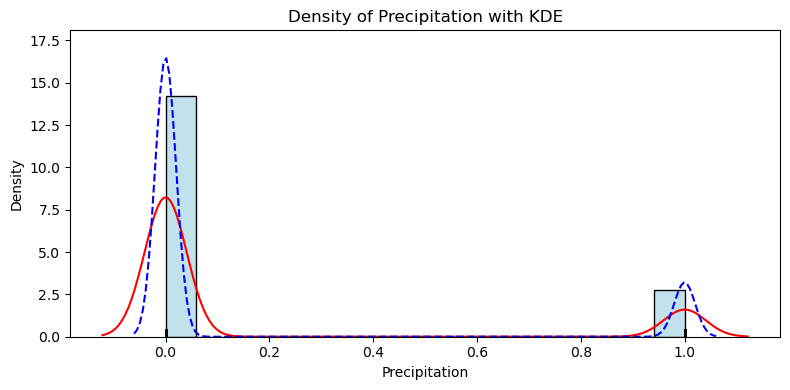

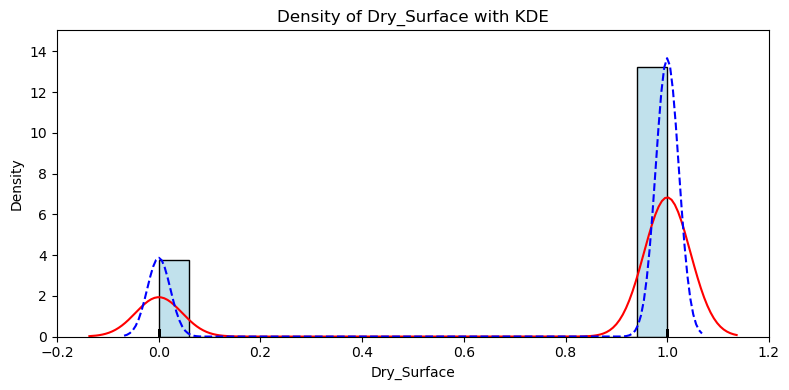

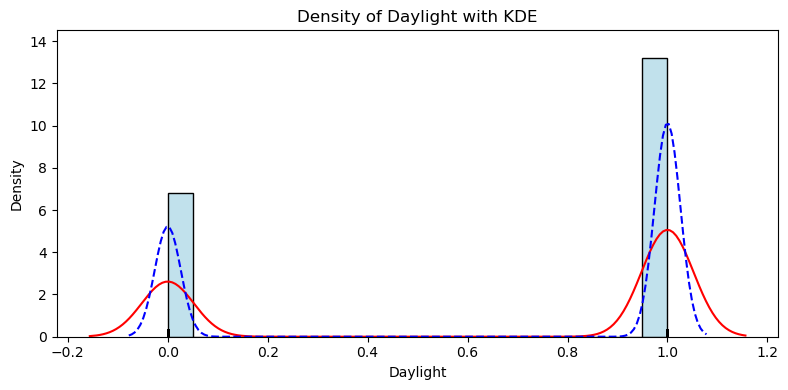

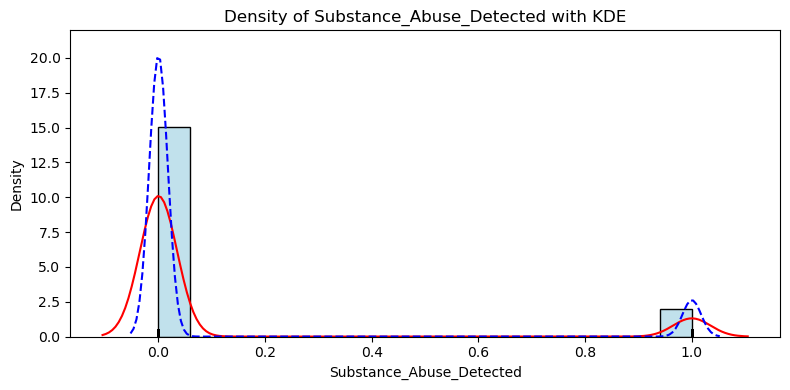

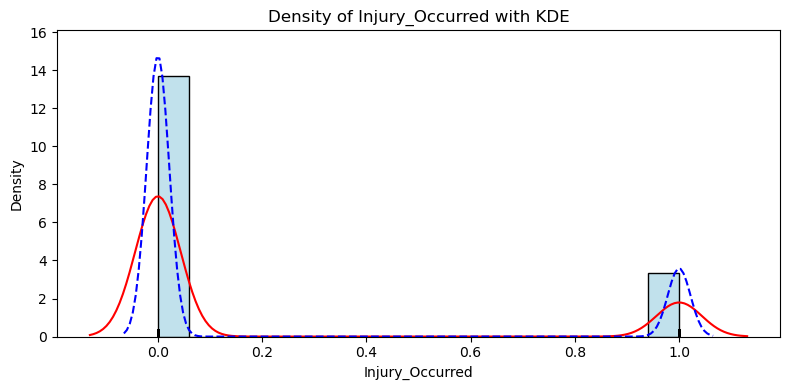

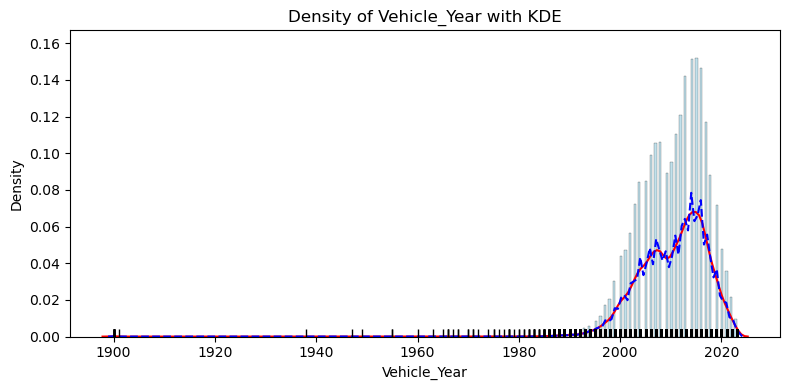

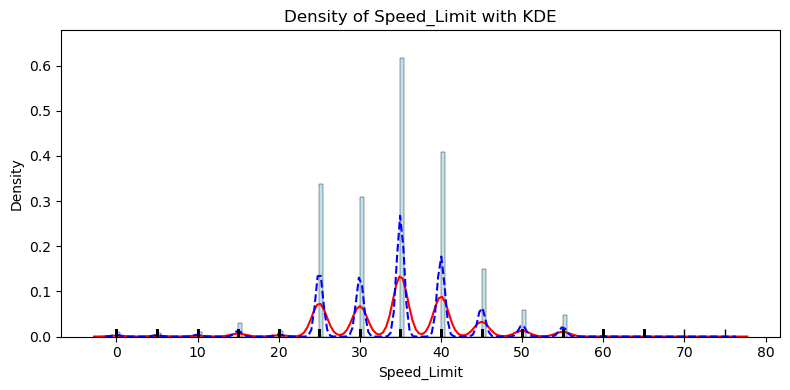

In [23]:
for col in crash_binary.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(crash_binary[col], kde=False, stat='density', color='lightblue')
    sns.kdeplot(crash_binary[col], color='red')
    sns.kdeplot(crash_binary[col], bw_adjust=0.5, color='blue', linestyle='--')  # less smooth
    sns.rugplot(crash_binary[col], color='black')
    plt.title(f'Density of {col} with KDE')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

**`Injury_Occurred`**  
- Most crashes result in no injuries, which could influence cutoff points in LPM, probit, and logit models.

**`Precipitation`**  
- Clear/cloudy weather (0) is far more common than other weather conditions (1).

**`Dry_Surface`**  
- Dry surface conditions (1) dominate the dataset, with fewer crashes on non-dry surfaces (0).

**`Daylight`**  
- Crashes occur more frequently in daylight (1) compared to other lighting conditions (0).

**`Substance_Abuse_Detected`**  
- `NONE DETECTED` (0) is overwhelmingly common, with few cases of substance abuse detected (1).

**`Vehicle_Year`**  
- Vehicle years are skewed toward newer models, mostly post-2000, with almost no vehicles before 1950.  
- Because we treat vehicle year as a continuous numerical variable, antique/collectible cars have very high leverage; consider excluding them.

**`Speed_Limit`**  
- Speed limits cluster around standard values (e.g., 20, 30, 40, 50 mph) rather than being uniformly distributed.

##### Fitted Distributions (Q-Q Plot and Cullen-Frey)

- The dataset primarily consists of binary variables, making techniques like Q-Q plots, Cullen-Frey plots, or Box-Cox transformations unnecessary, as these are suited for continuous or count data.
- For numeric variables (`Vehicle_Year` and `Speed_Limit`), we avoided transformations since their current distributions are intuitive, contextually meaningful, and provide sufficient explanatory power.
- Furthermore, transforming these variables would compromise explanatory reasoning, as interpreting values like the "log of speed limit" in relation to injury prevalence lacks practical relevance.
- *The above explanations were approved by Prof. Rojas during office hours.*

##### Correlation Plots

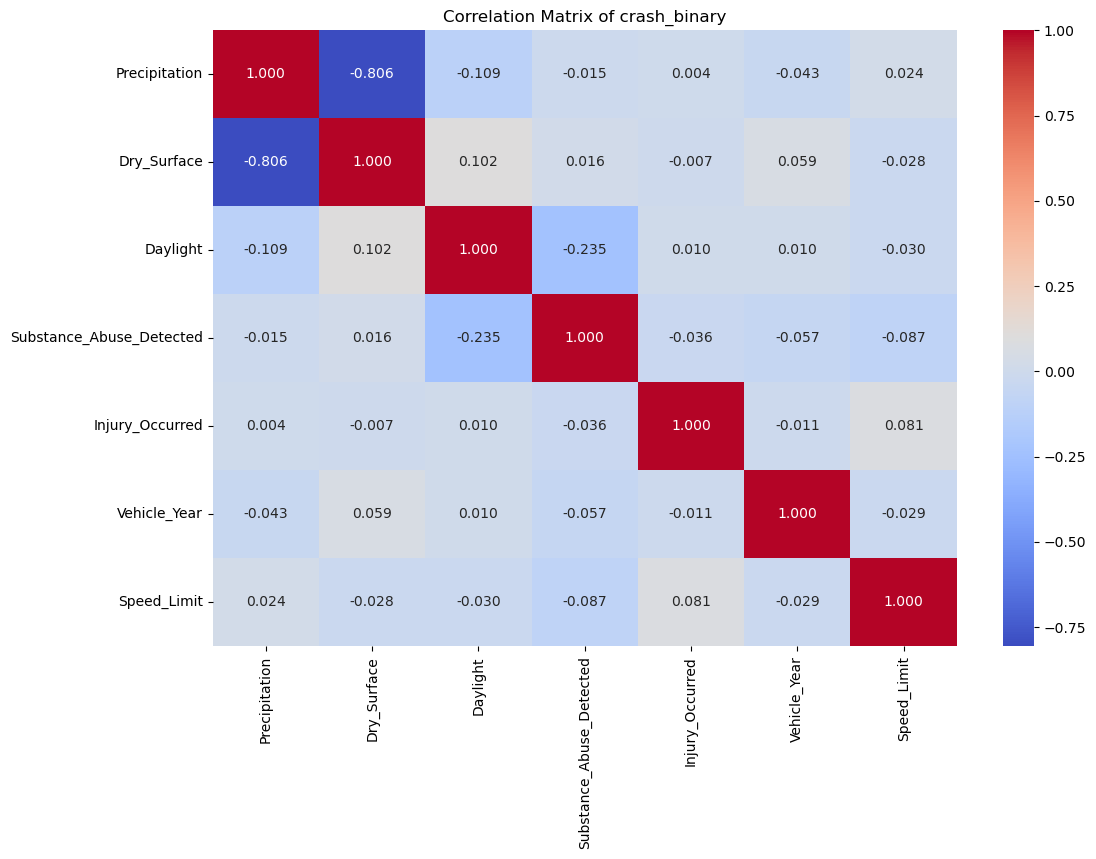

In [24]:
correlation_matrix = crash_binary.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of crash_binary")
plt.show()

- The correlation matrix shows a strong negative correlation (-0.806) between `Precipitation` and `Dry_Surface`.  
    - This result is expected, as weather conditions (e.g., rain) directly affect surface conditions (e.g., wet roads).  
- Since the correlation exceeds the multicollinearity threshold of 0.8, we will remove one of these variables to avoid redundancy and instability in the model.  
    - We will retain `Dry_Surface`, as it has a slightly stronger correlation with the dependent variable (`Injury_Occurred`), making it a better predictor in the model.  
    - This decision helps reduce multicollinearity while preserving the variable that provides the most explanatory power for injury occurrence.

In [25]:
crash_binary.drop('Precipitation', axis = 1, inplace = True)
crash_binary.head()

,Dry_Surface,Daylight,Substance_Abuse_Detected,Injury_Occurred,Vehicle_Year,Speed_Limit
1,1,1,0,0,2010,35
2,1,1,0,1,2021,35
3,1,0,0,0,2019,40
4,0,0,0,0,2014,20
6,0,0,0,0,2015,35


##### Box Plots

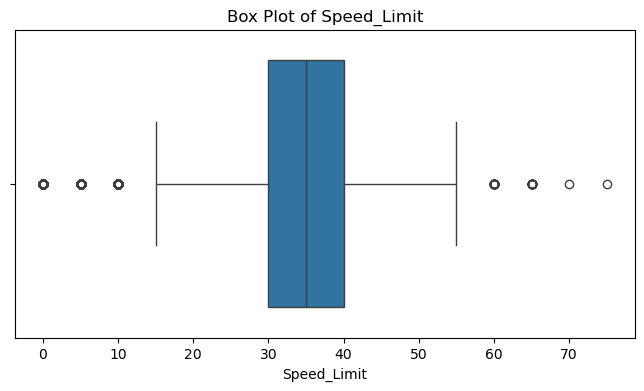

In [26]:
plt.figure(figsize = (8, 4))
sns.boxplot(x = crash_binary['Speed_Limit'])
plt.title(f'Box Plot of Speed_Limit')
plt.xlabel('Speed_Limit')
plt.show()

- Since the distribution of `Speed Limit` is symmetric, there is no indication of extreme outliers or irregularities. No data will be removed.

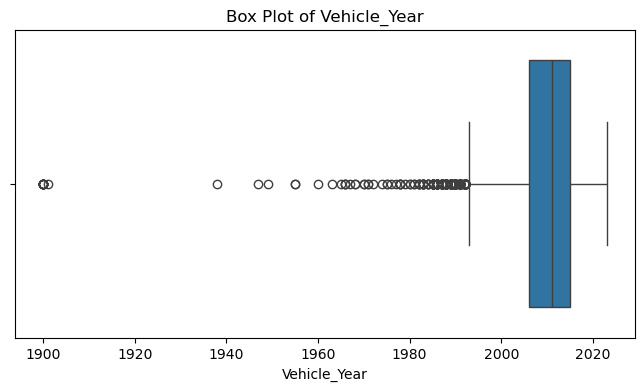

In [27]:
plt.figure(figsize = (8, 4))
sns.boxplot(x = crash_binary['Vehicle_Year'])
plt.title(f'Box Plot of Vehicle_Year')
plt.xlabel('Vehicle_Year')
plt.show()

- In the data cleaning process, we removed unrealistic entries: vehicles with a model year earlier than 1885 (since cars had not been invented) and later than 2024 (as the dataset covers the years 2016–2023).
- The Box Plot above highlights outliers representing vehicles with model years between 1900 and 1980.
- As explained in the histogram section, we treat vehicle year as a continuous numerical variable; we will remove these outliers.

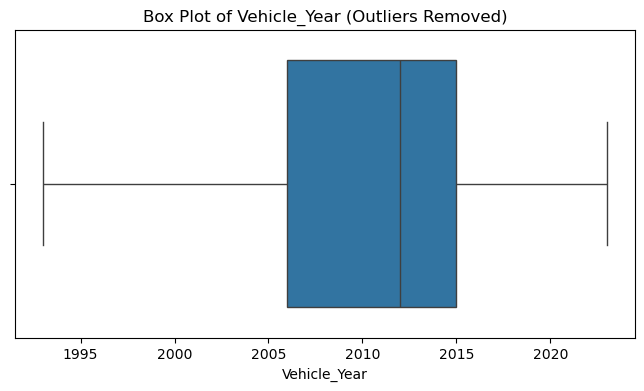

In [28]:
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

crash_binary = remove_outliers_iqr(crash_binary, 'Vehicle_Year')

plt.figure(figsize = (8, 4))
sns.boxplot(x = crash_binary['Vehicle_Year'])
plt.title(f'Box Plot of Vehicle_Year (Outliers Removed)')
plt.xlabel('Vehicle_Year')
plt.show()

##### Scatter Plots

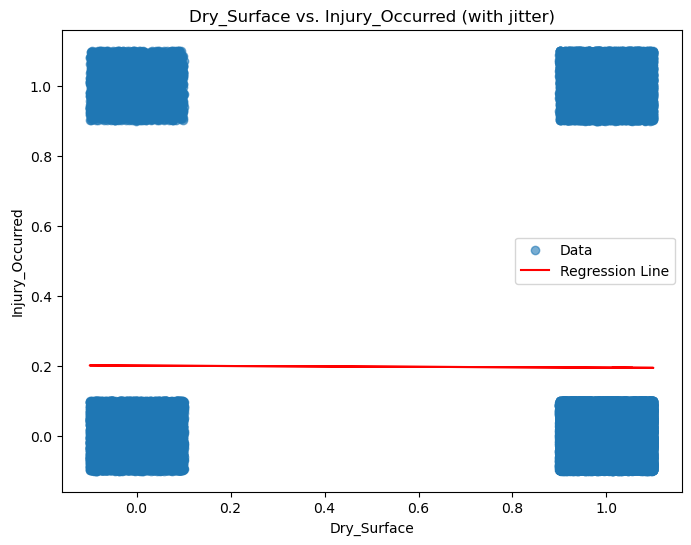

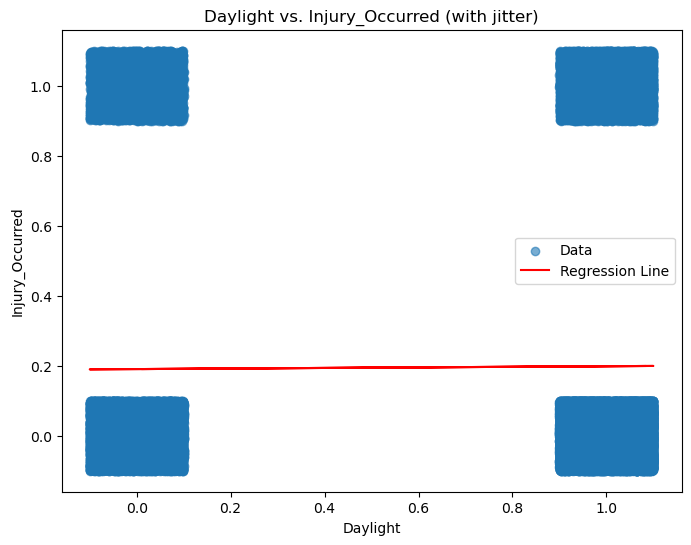

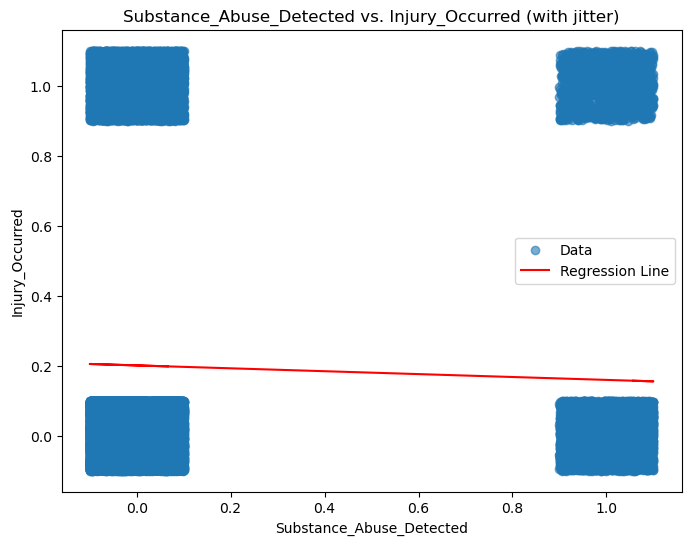

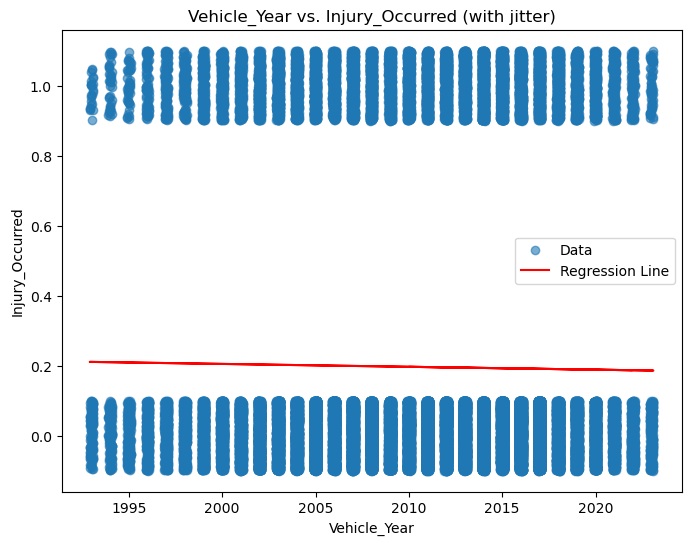

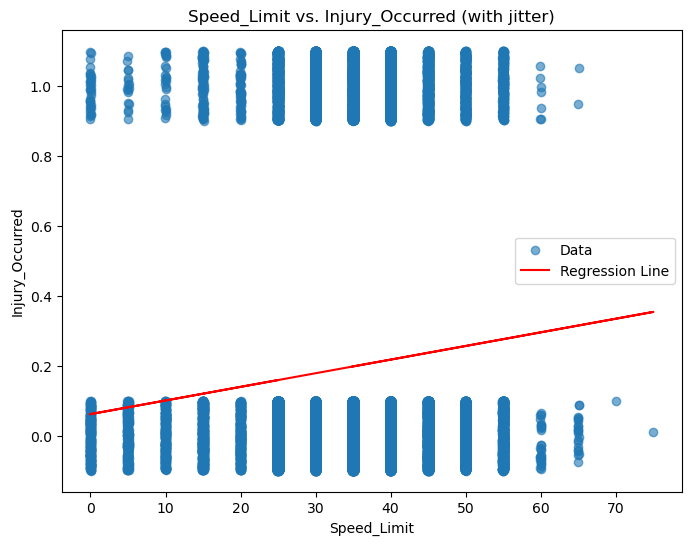

In [29]:
from scipy.stats import linregress

for col in crash_binary.columns:
    if col != 'Injury_Occurred':  # Ensure 'Injury Severity' is not compared with itself
        # Add jitter to both the independent and dependent variables
        jitter_x = crash_binary[col] + np.random.uniform(-0.1, 0.1, size=len(crash_binary[col]))
        jitter_y = crash_binary['Injury_Occurred'] + np.random.uniform(-0.1, 0.1, size=len(crash_binary['Injury_Occurred']))
        
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(jitter_x, jitter_y)
        
        # Create scatter plot with jitter
        plt.figure(figsize=(8, 6))
        plt.scatter(jitter_x, jitter_y, alpha=0.6, label='Data')
        
        # Add regression line
        regression_line = slope * jitter_x + intercept
        plt.plot(jitter_x, regression_line, color='red', label='Regression Line')
        
        # Customize plot
        plt.title(f'{col} vs. Injury_Occurred (with jitter)')
        plt.xlabel(col)
        plt.ylabel('Injury_Occurred')
        plt.legend()
        plt.show()

**`Dry_Surface` vs. `Injury_Occurred`:**
- There is a clear split between dry surfaces (1) and non-dry surfaces (0), with most data concentrated on dry surfaces.  
- The regression line is flat, indicating no significant relationship between surface condition and injury occurrence.  
- Surface conditions (dry vs. non-dry) do not appear to influence injury occurrence meaningfully.

**`Daylight` vs. `Injury_Occurred`:**
- Data forms two distinct clusters: daylight (1) and non-daylight (0), with most crashes occurring under daylight conditions.  
- A flat regression line suggests no strong relationship between lighting conditions and injury occurrence.  
- Daylight vs. non-daylight conditions do not significantly impact injury occurrence.

**`Substance_Abuse_Detected` vs. `Injury_Occurred`:**
- Two clear clusters exist: None Detected (0) and Substance Abuse Detected (1).  
- A slight downward trend indicates a weak negative relationship between substance abuse detection and injury occurrence.  
- The association is minimal and might reflect confounding or other underlying factors.

**`Vehicle_Year` vs. `Injury_Occurred`:**
- Most vehicles in the dataset are from recent years (post-2000).  
- A slight downward trend suggests a weak negative relationship between vehicle year and injury occurrence, likely reflecting improved safety features in newer vehicles.  

**`Speed_Limit` vs. `Injury_Occurred`:**
- Data clusters around standard speed limits (e.g., 30 mph, 50 mph).  
- A positive regression slope indicates that higher speed limits are associated with an increased likelihood of injury.  
- Higher speed limits are moderately and consistently associated with more injuries, making it a strong predictor.

##### Five Number Summary

In [30]:
print(crash_binary.describe())

        Dry_Surface      Daylight  Substance_Abuse_Detected  Injury_Occurred  \
count  62478.000000  62478.000000              62478.000000     62478.000000   
mean       0.779474      0.659240                  0.114488         0.195493   
std        0.414604      0.473969                  0.318406         0.396583   
min        0.000000      0.000000                  0.000000         0.000000   
25%        1.000000      0.000000                  0.000000         0.000000   
50%        1.000000      1.000000                  0.000000         0.000000   
75%        1.000000      1.000000                  0.000000         0.000000   
max        1.000000      1.000000                  1.000000         1.000000   

       Vehicle_Year   Speed_Limit  
count  62478.000000  62478.000000  
mean    2010.649028     34.470214  
std        6.161549      8.342628  
min     1993.000000      0.000000  
25%     2006.000000     30.000000  
50%     2012.000000     35.000000  
75%     2015.000000     40.

- **`Dry_Surface`**:
  - 77.9% of crashes occurred on dry surfaces (1), with the rest on non-dry surfaces (0).
  - The data is heavily skewed toward dry surfaces, as the 25th, 50th, and 75th percentiles are all 1.

- **`Daylight`**:
  - 65.9% of crashes happened during daylight conditions (1).
  - Most crashes occurred during daylight, but there’s still a significant number of crashes in non-daylight conditions (0).

- **`Substance_Abuse_Detected`**:
  - Substance abuse was detected in 11.4% of cases (1), while 88.6% had no substance abuse (0).
  - The data is strongly skewed toward "None Detected" (0), as the 25th, 50th, and 75th percentiles are all 0.

- **`Injury_Occurred`**:
  - 19.5% of crashes resulted in injury (1), while 80.5% did not (0).
  - The majority of crashes resulted in no injuries (0), with only a small proportion involving injuries.

- **`Vehicle_Year`**:
  - The average vehicle year is ~2010.
  - Most vehicles are relatively modern, with the 25th percentile at 2006 and the 75th percentile at 2015. Outliers exist with vehicles as old as 1993.

- **`Speed_Limit`**:
  - The average speed limit is 34.5 mph.
  - The 25th, 50th, and 75th percentiles are at 30, 35, and 40 mph, respectively, indicating clustering around standard speed limits.

### 3. Model Fitting
We will test the following three models for model fitting: a **linear probability model (LPM)**, a **probit model**, and a **logit model**. In our models, the dependent variable is `Injury_Occurred`, where 0 indicates no injury occurred in the crash, and 1 indicates any injury.

We will compare the models' performance with their **sensitivity** because missing injured individuals (false negatives) could lead to severe consequences, such as lack of timely medical attention or insufficient safety measures. We will also note **PPV** to measure the confidence in the models' positive predictions.

In [60]:
formula = 'Injury_Occurred ~ Dry_Surface + Daylight + Substance_Abuse_Detected + Vehicle_Year + Speed_Limit'

In [61]:
def calculate_metrics(TP, TN, FP, FN):
    """Calculate sensitivity, specificity, PPV, NPV, and accuracy."""
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0  # Sensitivity (Recall)
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity
    ppv = TP / (TP + FP) if (TP + FP) != 0 else 0          # Positive Predictive Value (PPV)
    npv = TN / (TN + FN) if (TN + FN) != 0 else 0          # Negative Predictive Value (NPV)
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0  # Accuracy
    return {
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "PPV": ppv,
        "NPV": npv,
        "Accuracy": accuracy
    }

def evaluate_model(model, data, target_col, cutoff):
    """
    Generate confusion matrix and evaluate metrics for the given model.
    """
    predicted_probs = model.predict()  # Predicted probabilities
    predicted_classes = [1 if prob > cutoff else 0 for prob in predicted_probs]  # Classify
    cm = confusion_matrix(y_true=data[target_col], y_pred=predicted_classes)
    TN, FP, FN, TP = cm.ravel()
    return calculate_metrics(TP, TN, FP, FN)

def conf_matrix(model, data, target_col, cutoff, model_name="Model"):
    """
    Display confusion matrix and performance metrics.
    """
    predicted_probs = model.predict()  # Predicted probabilities
    predicted_classes = [1 if prob > cutoff else 0 for prob in predicted_probs]  # Classify
    cm = confusion_matrix(y_true=data[target_col], y_pred=predicted_classes)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Injury', 'Injury'])
    cm_display.plot()
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def plot_model_predictions(model, formula, data, predictor, fixed_values, points=200, xlabel=None, ylabel=None, cutoff=None):
    """
    Plot model predictions and observed data with an optional cutoff line.
    """
    predictor_range = np.linspace(data[predictor].min(), data[predictor].max(), points)
    prediction_data = pd.DataFrame({predictor: predictor_range})
    for var, value in fixed_values.items():
        prediction_data[var] = value

    predictions = model.predict(prediction_data)

    plt.plot(predictor_range, predictions, label='Predicted')
    plt.scatter(data[predictor], data[formula.split('~')[0].strip()], color='black', alpha=0.6, label='Observed')
    if cutoff is not None:
        plt.axhline(y=cutoff, color='red', linestyle='--', label=f'Cutoff = {cutoff:.3f}')
    plt.ylim(-0.05, 1.05)
    plt.xlabel(xlabel if xlabel else predictor)
    plt.ylabel(ylabel if ylabel else formula.split('~')[0].strip())
    plt.legend()
    plt.show()

#### Linear Probability Model (LPM)

In [64]:
lpm_model = smf.ols(formula, data=crash_binary).fit()
print(lpm_model.summary())

                            OLS Regression Results                            
Dep. Variable:        Injury_Occurred   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     97.12
Date:                Fri, 06 Dec 2024   Prob (F-statistic):          2.58e-102
Time:                        11:09:21   Log-Likelihood:                -30626.
No. Observations:               62478   AIC:                         6.126e+04
Df Residuals:                   62472   BIC:                         6.132e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

- R-squared: 0.008; The model explains only 0.8% of the variance in injury occurrence, indicating limited predictive power.
- Significant Variables:
  - `Speed_Limit`: Positive coefficient (0.0038), p < 0.05; Higher speed limits are associated with a higher likelihood of injury.
  - `Substance_Abuse_Detected`: Negative coefficient (-0.0341), p < 0.05; Surprisingly, substance abuse detection correlates with a lower likelihood of injury, suggesting potential confounding.
  - `Vehicle_Year`: Negative coefficient (-0.0007), p < 0.05; Newer vehicles are weakly associated with a lower likelihood of injury.
- Other Variables:
  - `Daylight` and `Dry_Surface` are not statistically significant (p > 0.05).
- Notes:
  - Coefficients represent the change in probability of injury for a one-unit increase in the predictor.
  - Interpretation is straightforward but lacks robustness due to limitations of LPM.

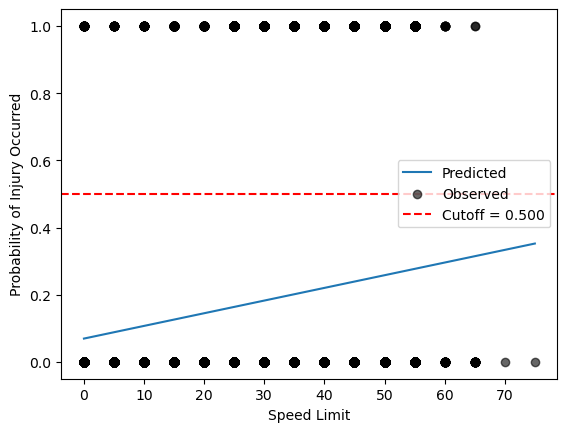

In [65]:
# Plot predictions of LPM
plot_model_predictions(
    model=lpm_model,
    formula=formula,
    data=crash_binary,
    predictor='Speed_Limit',
    fixed_values={'Dry_Surface':1, 'Daylight':1, 'Substance_Abuse_Detected': 0, 'Vehicle_Year': 2012},
    xlabel='Speed Limit',
    ylabel='Probability of Injury Occurred',
    cutoff = 0.5
)

- All of our predicted data is below the 0.5 cutoff.
- Confirm this observation by checking the distribution of fitted values with a histogram:

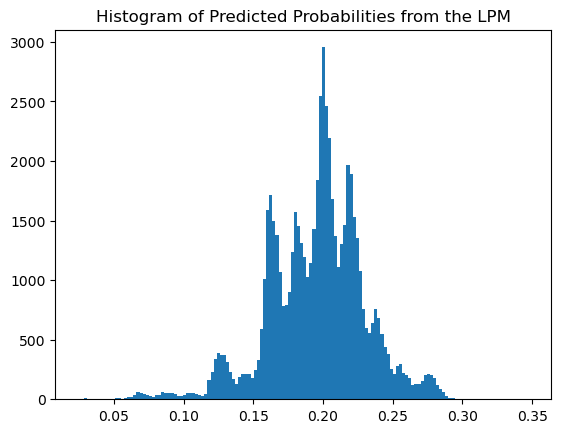

In [69]:
plt.figure()
plt.hist(lpm_model.fittedvalues, bins = 'fd')
plt.title('Histogram of Predicted Probabilities from the LPM')
plt.show()

- The observations for the variable `Injury_Severity` are heavily skewed towards 0, which biases the LPM to predict values closer to 0.
- As a result, using a cutoff of 0.5 for the predicted probabilities leads to all predictions being classified as 0.
- To address this imbalance, we adjusted the cutoff value to match the proportion of true positive injury cases in the dataset, ensuring that the predictions better reflect the observed data distribution.
    - We will also do the same for downstream model fitting for probit and logit.

In [74]:
cutoff = crash_binary['Injury_Occurred'].mean()
print(f"Adjusted cutoff for imbalanced dataset: {cutoff:.3f}")

Adjusted cutoff for imbalanced dataset: 0.195


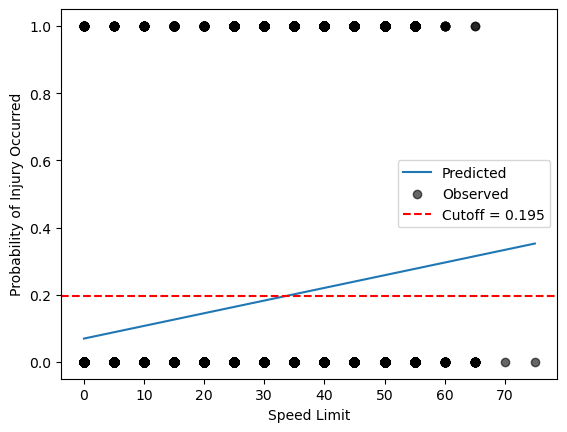

In [75]:
# Plot predictions of LPM (with new cutoff)
plot_model_predictions(
    model=lpm_model,
    formula=formula,
    data=crash_binary,
    predictor='Speed_Limit',
    fixed_values={'Dry_Surface':1, 'Daylight':1, 'Substance_Abuse_Detected': 0, 'Vehicle_Year': 2012},
    xlabel='Speed Limit',
    ylabel='Probability of Injury Occurred',
    cutoff = cutoff
)

- Linear increase in predicted probability as the speed limit increases, typical of LPM.
- At low speed limits, most predictions remain below the cutoff. Predictions only cross the cutoff at higher speed limits.
- LPM continues to struggle with respecting binary data probability distribution and boundaries (0-1), showing a less natural fit.

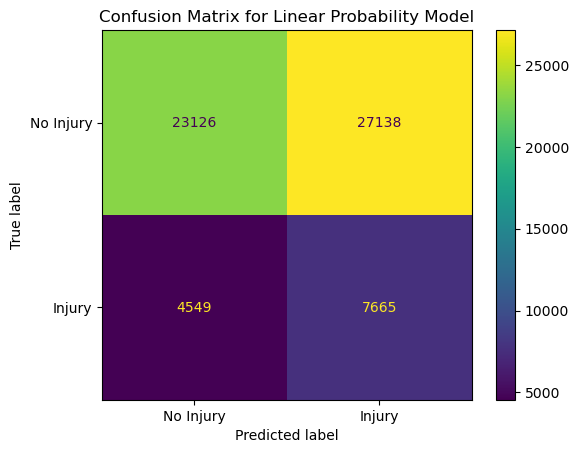

In [111]:
conf_matrix(
    model=lpm_model,
    data=crash_binary,
    target_col='Injury_Occurred',
    cutoff=cutoff,
    model_name="Linear Probability Model"
)

- High false positive rate, leading to poor specificity, though sensitivity is reasonable.

#### Probit Model

In [77]:
probit_model = smf.probit(formula, crash_binary).fit(disp=0)
print(probit_model.summary())

                          Probit Regression Results                           
Dep. Variable:        Injury_Occurred   No. Observations:                62478
Model:                         Probit   Df Residuals:                    62472
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                0.008103
Time:                        11:12:56   Log-Likelihood:                -30620.
converged:                       True   LL-Null:                       -30870.
Covariance Type:            nonrobust   LLR p-value:                6.995e-106
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.0784      1.888      2.160      0.031       0.378       7.778
Dry_Surface                 -0.0134      0.014     -0.958      0.338      -0.041       0.

- Pseudo R-squared: 0.008; Similar explanatory power as the logit model.
- Significant Variables:
  - `Speed_Limit`: Positive coefficient (0.0142), p < 0.05; Higher speed limits increase the probability of injury.
  - `Substance_Abuse_Detected`: Negative coefficient (-0.1362), p < 0.05; Associated with lower injury probability, potentially confounded.
  - `Vehicle_Year`: Negative coefficient (-0.0027), p < 0.05; Newer vehicles slightly decrease injury likelihood.
- Other Variables:
  - `Daylight` and `Dry_Surface` are not statistically significant (p > 0.05).
- Model Fit:
  - The LLR p-value (< 0.05) confirms the model’s superiority over the null model.

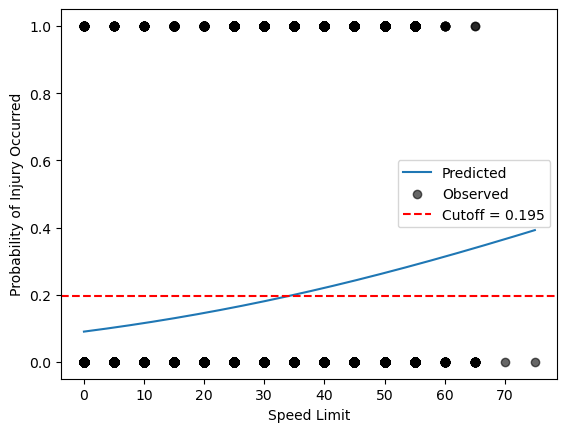

In [78]:
# Plot predictions of Probit model
plot_model_predictions(
    model=probit_model,
    formula=formula,
    data=crash_binary,
    predictor='Speed_Limit',
    fixed_values={'Dry_Surface':1, 'Daylight':1, 'Substance_Abuse_Detected': 0, 'Vehicle_Year': 2012},
    xlabel='Speed Limit',
    ylabel='Probability of Injury Occurred',
    cutoff = cutoff
)

- Compared to the lecture’s example, our observed points don’t cluster neatly around 0 or 1 for given predictor values.
    - Instead, they’re more intermixed, suggesting that the single predictor variable on its own doesn’t sharply distinguish between cases where the dependent variable is 0 or 1.
- Nonlinear curve, reflecting a more realistic relationship between `Speed_Limit` and `Injury_Occurred`.
    - Predicted probabilities cross the cutoff at moderate speed limits, gradually aligning with observed patterns.
    - It is a better fit than LPM due to the nonlinear relationship, though some discrepancies persist due to skewed observations.

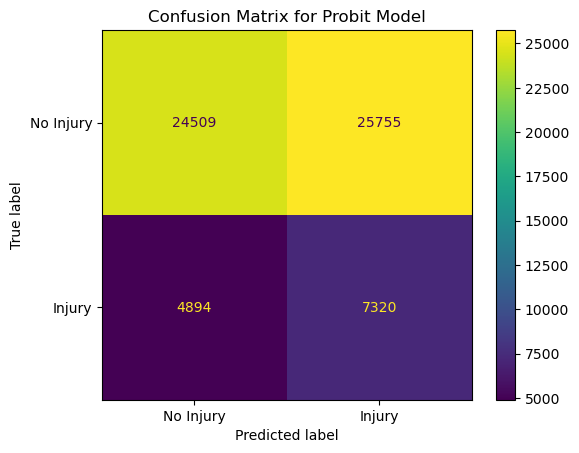

In [79]:
conf_matrix(
    model=probit_model,
    data=crash_binary,
    target_col='Injury_Occurred',
    cutoff=cutoff,
    model_name="Probit Model"
)

- Improved specificity compared to LPM, but sensitivity slightly reduced; balanced performance.

#### Logit Model

In [80]:
# Fit model
logit_model = smf.logit(formula,data=crash_binary).fit(disp = 0)
print(logit_model.summary())

                           Logit Regression Results                           
Dep. Variable:        Injury_Occurred   No. Observations:                62478
Model:                          Logit   Df Residuals:                    62472
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                0.007996
Time:                        11:13:58   Log-Likelihood:                -30623.
converged:                       True   LL-Null:                       -30870.
Covariance Type:            nonrobust   LLR p-value:                1.864e-104
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    7.2305      3.312      2.183      0.029       0.739      13.722
Dry_Surface                 -0.0231      0.024     -0.945      0.344      -0.071       0.

- Pseudo R-squared: 0.008; Low explanatory power but typical for binary models.
- Significant Variables:
  - `Speed_Limit`: Positive coefficient (0.0247), p < 0.05; Higher speed limits significantly increase the odds of injury.
  - `Substance_Abuse_Detected`: Negative coefficient (-0.2409), p < 0.05; Associated with lower odds of injury, possibly due to confounding.
  - `Vehicle_Year`: Negative coefficient (-0.0047), p < 0.05; Newer vehicles weakly reduce the odds of injury.
- Other Variables:
  - `Daylight` and `Dry_Surface` are not statistically significant (p > 0.05).
- Model Fit:
  - The LLR p-value (< 0.05) indicates that the model fits better than the null model.

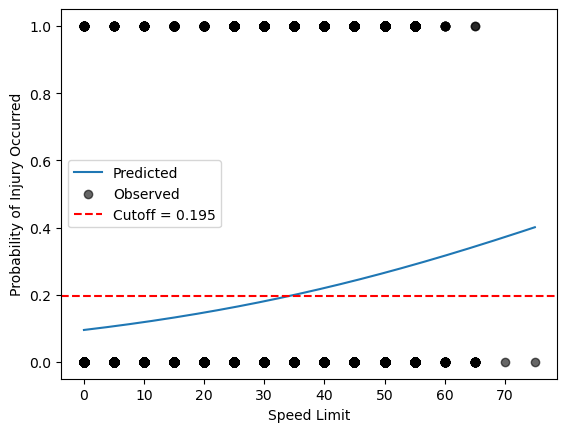

In [81]:
# Plot predictions of Logit model
plot_model_predictions(
    model=logit_model,
    formula=formula,
    data=crash_binary,
    predictor='Speed_Limit',
    fixed_values={'Dry_Surface':1, 'Daylight':1, 'Substance_Abuse_Detected': 0, 'Vehicle_Year': 2012},
    xlabel='Speed Limit',
    ylabel='Probability of Injury Occurred',
    cutoff = cutoff
)

- Curve similar to Probit, capturing the nonlinear probability increase.
- Predicted probabilities cross the cutoff like Probit; suitable for skewed data.

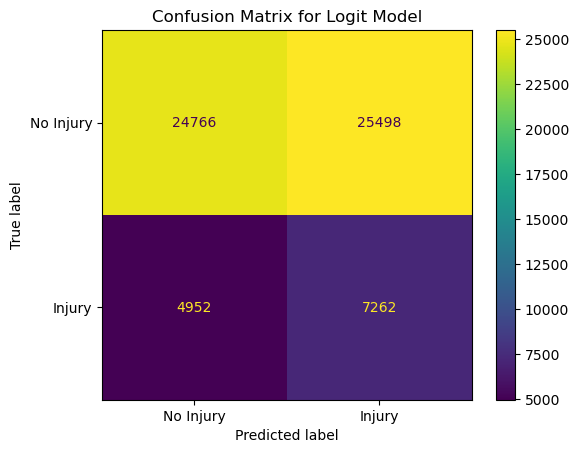

In [82]:
conf_matrix(
    model=logit_model,
    data=crash_binary,
    target_col='Injury_Occurred',
    cutoff=cutoff,
    model_name="Logit Model"
)

- Similar performance to Probit with slightly better balance in true/false positive rates.

#### Logit with Selected Variables

- Across all previous models, `Speed_Limit` is the strongest and most consistent predictor, positively associated with injury occurrence.
- `Substance_Abuse_Detected` has an unexpected negative relationship with injury occurrence, suggesting confounding or reverse causality.
- `Vehicle_Year` consistently shows a weak but significant negative relationship with injury, indicating that newer vehicles might be safer.
- `Daylight` and `Dry_Surface` are not significant predictors in any model.
- Therefore, we will **remove `Daylight` and `Dry_Surface` and make a new prediction with the logit model.**

In [83]:
selected_formula = 'Injury_Occurred ~ Speed_Limit + Substance_Abuse_Detected + Vehicle_Year'

In [84]:
# Fit model
logit_model_2 = smf.logit(selected_formula, data=crash_binary).fit(disp = 0)
print(logit_model_2.summary())

                           Logit Regression Results                           
Dep. Variable:        Injury_Occurred   No. Observations:                62478
Model:                          Logit   Df Residuals:                    62474
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                0.007942
Time:                        11:14:21   Log-Likelihood:                -30625.
converged:                       True   LL-Null:                       -30870.
Covariance Type:            nonrobust   LLR p-value:                5.854e-106
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    7.4639      3.306      2.258      0.024       0.985      13.943
Speed_Limit                  0.0246      0.001     19.681      0.000       0.022       0.

- Pseudo R-squared: 0.0079; The model has low explanatory power, but this is typical for binary outcome models.
- Significant Variables:
  - `Speed_Limit`: 0.0246, p < 0.05; Higher speed limits significantly increase the odds of injury. Each 1-unit increase in speed limit raises the log-odds of injury by 0.0246.
  - `Substance_Abuse_Detected`: -0.2543, p < 0.05; Substance abuse detection is associated with lower odds of injury. This unexpected negative relationship might be due to confounding factors.
  - `Vehicle_Year`: -0.0048, p < 0.05; Newer vehicles are weakly associated with lower odds of injury. Each additional year decreases the log-odds of injury by 0.0048.
- Model Fit:
  - LLR p-value: $5.854 \times 10^{-106}$; The model fits significantly better than the null model, as indicated by the likelihood ratio test.

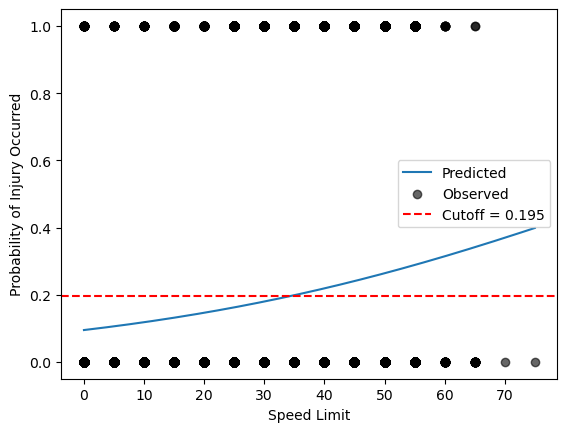

In [85]:
# Plot predictions of Logit model with selected variables
plot_model_predictions(
    model=logit_model_2,
    formula=selected_formula,
    data=crash_binary,
    predictor='Speed_Limit',
    fixed_values={'Dry_Surface':1, 'Daylight':1, 'Substance_Abuse_Detected': 0, 'Vehicle_Year': 2012},
    xlabel='Speed Limit',
    ylabel='Probability of Injury Occurred',
    cutoff = cutoff
)

- Curve persists, slightly modified to reflect the influence of selected predictors.
- We aim to use a focused model to improve alignment with observed data while balancing simplicity and predictive accuracy.

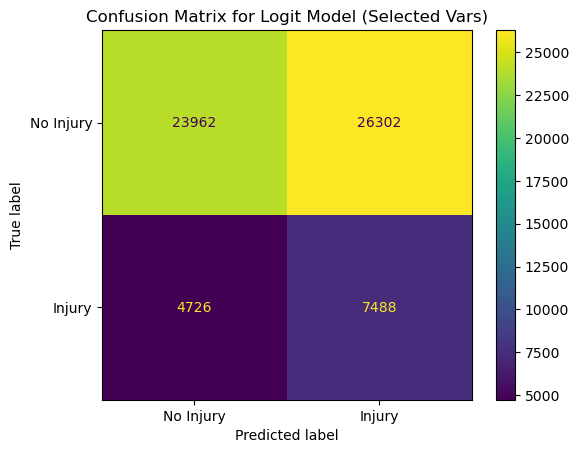

In [86]:
conf_matrix(
    model=logit_model_2,
    data=crash_binary,
    target_col='Injury_Occurred',
    cutoff=cutoff,
    model_name="Logit Model (Selected Vars)"
)

- Slightly improved sensitivity compared to the standard Logit model, but with increased false positives.

#### Evaluation Metrics Table

In [87]:
metrics = {
    "LPM": evaluate_model(lpm_model, crash_binary, 'Injury_Occurred', cutoff),
    "Probit": evaluate_model(probit_model, crash_binary, 'Injury_Occurred', cutoff),
    "Logit": evaluate_model(logit_model, crash_binary, 'Injury_Occurred', cutoff),
    "Logit (Selected Vars)": evaluate_model(logit_model_2, crash_binary, 'Injury_Occurred', cutoff)
}

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

                       Sensitivity  Specificity       PPV       NPV  Accuracy
LPM                       0.627559     0.460091  0.220240  0.835628  0.492829
Probit                    0.599312     0.487605  0.221315  0.833554  0.509443
Logit                     0.594564     0.492718  0.221673  0.833367  0.512628
Logit (Selected Vars)     0.613067     0.476723  0.221604  0.835262  0.503377


**Key Observations from Metrics:**
1. **Sensitivity (Primary Metric):**
   - **LPM** has the highest sensitivity (0.6276), indicating it is least likely to miss injured individuals.
   - **Logit Model (Selected Variables)** has the second-highest sensitivity (0.6131), offering a better balance of sensitivity and specificity than LPM.

2. **Positive Predictive Value (PPV):**
   - All models have very similar PPV (around 0.22), meaning none offers a significant advantage in the confidence of positive predictions.

3. **Trade-offs:**
   - **LPM** achieves the best sensitivity but at the cost of the lowest specificity (0.4601), leading to a high false positive rate.
   - **Logit Model (Selected Variables)** sacrifices some sensitivity but improves specificity slightly, offering a more balanced performance overall.

**Our Final Verdict:**
- **Use the Logit Model with Selected Variables.**
  - **Why?** It achieves high sensitivity (0.6131), close to the LPM, while offering slightly better specificity (0.4767) than the LPM.
  - The better balance between sensitivity and specificity makes it a more robust choice in scenarios where sensitivity is critical but false positives are also a concern.

### 4. Predictions
This section applies our finalized model to distinct crash scenarios, each defined by a specific road, vehicle, or driver condition. By evaluating the model’s predictions on data subsets where these conditions apply, we can determine how well it generalizes beyond the overall dataset. Specifically, we will test:

1. **Crashes with Speed Limit > 25 mph:** Examine if the model can accurately predict injuries on busier roads with higher speed limits compared to areas with lower speed limits.

2. **Crashes with Driver Substance Abuse:** Evaluate the model’s ability to predict injuries when substance use is detected, an important scenario that could influence driver behavior and crash severity.

3. **Crashes Involving Older Vehicles (Vehicle Year < 2003):** Assess how the model detects injuries in older cars, which may differ in safety features and crashworthiness from newer models.

4. **Crashes on Non-Dry Surfaces:** Determine how the model predicts injuries when the road surface is compromised (e.g., wet or icy), a factor that often affects crash severity.

For each scenario, we use the Logit model with selected variables and apply it to the relevant subset of the dataset. We then evaluate standard classification metrics (sensitivity, specificity, PPV, NPV, accuracy) for each scenario, providing insights into the model’s reliability and potential areas for improvement.

In [112]:
def evaluate_prediction_task(model, data, test_filter, cutoff):
    """
    Evaluate the performance of a pre-trained model on a specified subset of the data.
    
    Parameters:
        model (statsmodels model): A fitted model object (already trained on the full training set).
        data (pd.DataFrame): The dataset containing crash data, including Injury_Occurred and predictors.
        test_filter (pd.Series or np.array): Boolean mask to select the test subset of the data.
        cutoff (float): Threshold for converting predicted probabilities into binary classifications.
    
    Returns:
        dict: Evaluation metrics (Sensitivity, Specificity, PPV, NPV, Accuracy).
    """
    # Extract test data based on the provided filter
    test_data = data[test_filter]

    # Predict probabilities for the test subset
    predicted_probs = model.predict(test_data)
    predicted_classes = (predicted_probs >= cutoff).astype(int)

    # True labels
    y_true = test_data['Injury_Occurred']

    # Generate confusion matrix
    cm = confusion_matrix(y_true=y_true, y_pred=predicted_classes)
    TN, FP, FN, TP = cm.ravel()

    # Calculate metrics
    metrics = calculate_metrics(TP, TN, FP, FN)

    # Display the confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Injury', 'Injury'])
    cm_display.plot()
    plt.title("Evaluation Task: Confusion Matrix")
    plt.show()

    return metrics

#### a. Prediction on crashes where speed limit is over 25 mph (School zones and neighborhoods vs. Busy roads)

a. Predicting injury in crashes with Speed Limit > 25 mph


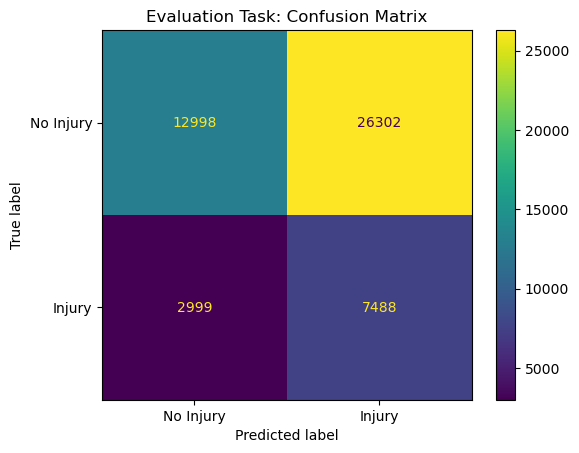

{'Sensitivity': 0.7140268904357776,
 'Specificity': 0.33073791348600506,
 'PPV': 0.22160402485942587,
 'NPV': 0.8125273488779146,
 'Accuracy': 0.4114728744451363}

In [138]:
print("a. Predicting injury in crashes with Speed Limit > 25 mph")
evaluate_prediction_task(logit_model_2, crash_binary, crash_binary['Speed_Limit'] > 25, cutoff)

- **Sensitivity (~0.71)**: Captures about 7 in 10 injuries, which is reasonably high.  
- **Specificity (~0.33)**: Very low; many non-injury cases are incorrectly flagged as injuries.  
- **PPV (~0.22)**: When it predicts injury, it’s right only about 1 in 5 times, limiting trust in positive predictions.  
- **NPV (~0.81)**: Strong at ruling out injuries; if it predicts no injury, it’s usually correct.  
- **Accuracy (~0.41)**: Overall, not much better than random guessing, indicating a lackluster performance despite good sensitivity.

#### b. Predictions on crashes where the driver has substance abuse

b. Predicting injury in crashes where Substance Abuse Detected


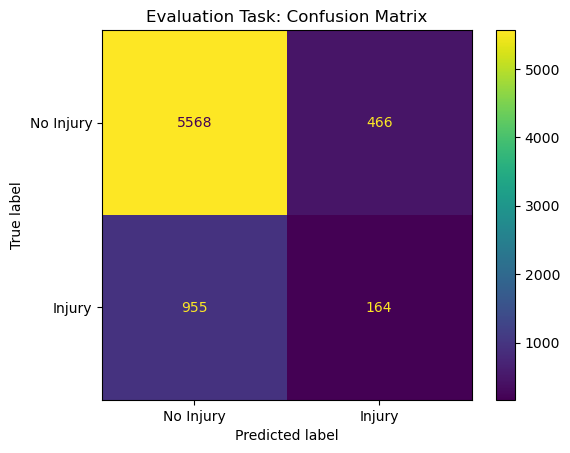

{'Sensitivity': 0.14655942806076855,
 'Specificity': 0.9227709645343056,
 'PPV': 0.26031746031746034,
 'NPV': 0.8535949716388165,
 'Accuracy': 0.8013420942261988}

In [137]:
print("b. Predicting injury in crashes where Substance Abuse Detected")
evaluate_prediction_task(logit_model_2, crash_binary, crash_binary['Substance_Abuse_Detected'] == 1, cutoff)

- **Sensitivity (~0.15)**: Struggles to identify actual injuries, missing about 85% of them.  
- **Specificity (~0.92)**: Very good at correctly identifying non-injury cases, resulting in fewer false alarms here.  
- **PPV (~0.26)**: Slightly better than the other scenarios, but still low; positive predictions remain unreliable.  
- **NPV (~0.85)**: Reliable at confirming no injury.  
- **Accuracy (~0.80)**: High accuracy largely reflects the model’s success at identifying the majority non-injury class rather than balanced performance.

#### c. Predictions on crashes where vehicle year is older than 2003

c. Predicting injury in crashes with Vehicle Year older than 2003


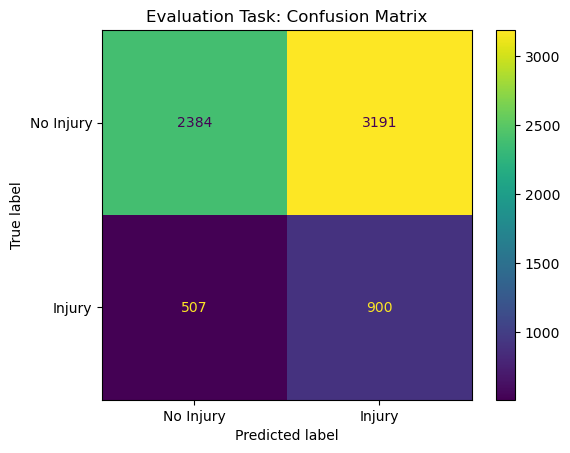

{'Sensitivity': 0.6396588486140725,
 'Specificity': 0.4276233183856502,
 'PPV': 0.21999511121975068,
 'NPV': 0.8246281563472847,
 'Accuracy': 0.47035233457462045}

In [139]:
print("c. Predicting injury in crashes with Vehicle Year older than 2003")
evaluate_prediction_task(logit_model_2, crash_binary, crash_binary['Vehicle_Year'] < 2003, cutoff)

- **Sensitivity (~0.64)**: Captures nearly two-thirds of actual injuries, a moderate improvement over some scenarios.  
- **Specificity (~0.43)**: Still low, resulting in a substantial number of false positives.  
- **PPV (~0.22)**: Consistent low PPV means many positive calls are incorrect.  
- **NPV (~0.82)**: Maintains strong ability to correctly predict no injury.  
- **Accuracy (~0.47)**: Slightly less than half correct, indicating the model is barely improving over random classification.

#### d. Predictions on crashes where the the surface is not dry

d. Predicting injury in crashes where Surface is Not Dry


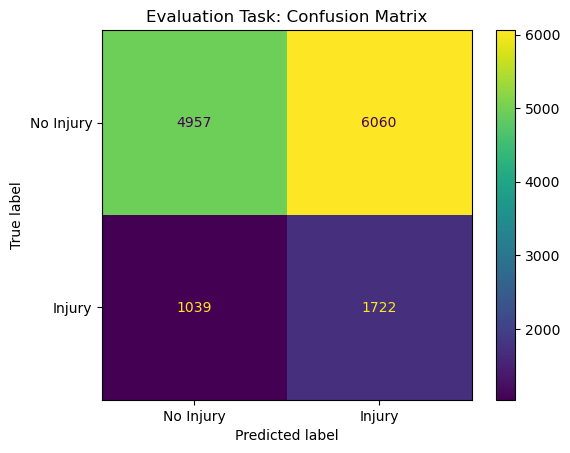

{'Sensitivity': 0.6236870699022093,
 'Specificity': 0.44994100027230644,
 'PPV': 0.2212798766383963,
 'NPV': 0.826717811874583,
 'Accuracy': 0.4847583103498331}

In [140]:
print("d. Predicting injury in crashes where Surface is Not Dry")
evaluate_prediction_task(logit_model_2, crash_binary, crash_binary['Dry_Surface'] == 0, cutoff)

- **Sensitivity (~0.62)**: Identifies a good portion of injuries, improving injury detection somewhat.  
- **Specificity (~0.45)**: Nearly half of non-injury cases are correctly identified, but this still allows too many false positives.  
- **PPV (~0.22)**: Remains low; positive predictions cannot be fully trusted.  
- **NPV (~0.83)**: Continues the trend of correctly identifying most no-injury cases.  
- **Accuracy (~0.48)**: Slightly less than half correct, indicating the model is barely improving over random classification.

#### Conclusion:
- The model consistently shows moderate-to-high **NPV**, making it useful for ruling out injuries.  
- **PPV** remains low across all scenarios, meaning positive predictions for injury are rarely reliable.  
- **Sensitivity** and **Specificity** vary widely, suggesting the model’s performance heavily depends on the scenario.  
- Despite some bright spots (like good specificity in the substance abuse scenario or decent sensitivity in the high-speed or older-vehicle conditions), the model struggles to balance both detecting injuries and avoiding false alarms.

- Possible factors that may have contributed to the model's low reliability include:
    - **Data Reduction:** Heavy filtering and feature removal likely discarded valuable predictors and crash details.  
    - **Imbalanced Target:** The rare occurrence of injuries biased the model toward predicting “no injury.”  
    - **Coarse Feature Encoding:** Binary conversions of complex categories stripped away potentially important subtleties.  
    - **Weak Predictors:** Chosen variables explained little variance; some were statistically insignificant.  
    - **Confounding Factors:** Unexpected negative relationships (i.e., substance abuse) suggest missing variables or confounders.  
    - **Limited Modeling Complexity:** Minimal feature engineering, no interaction terms, and reliance on simple linear/logistic methods.  